In [3]:
# Importing the necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy
import os
import pandas as pd
import argparse
import h5py
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import itertools
from matplotlib import pyplot as plt
from scipy.stats import zscore

# Defining the model

In this notebook I will use a variational auto encvoder to do the anamoly detection, this is differnt from the original auto encoder in that it maps the input to a latent space of a probability distribution. Lets see how it performs in comparison to the AE and the purely Z-score method

In [4]:
class VariationalAutoencoder(nn.Module):
    """
    Description:
    ------------
    Create a very simple variational autoencoder for detecting fraud transactions in credit card data. 
    """
    
    def __init__(self, input_dim=11, hidden_dim=100, latent_dim=10):
        super(VariationalAutoencoder, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)     # Mean
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim) # Log Variance

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        h = torch.relu(self.fc4(h))
        return self.fc5(h)  # No activation for final output (regression task)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)  # Reconstruction loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence
    return recon_loss + kl_divergence

In [9]:
def train_vae(data_path, model_path, batch_size, epochs, learning_rate, num_workers, log_interval):
    """
    Train a Variational Autoencoder (VAE) on the given dataset.
    """

    # Load and preprocess data
    df = pd.read_hdf(data_path, key='fraud_dataset')
    X = StandardScaler().fit_transform(df)
    X_tensor = torch.tensor(X, dtype=torch.float32)

    dataset = TensorDataset(X_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    # Initialize the VAE model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VariationalAutoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data,) in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_data, mu, logvar = model(data)
            loss = loss_function(recon_data, data, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # if batch_idx % log_interval == 0:
                # print(f"Epoch {epoch+1}  [{batch_idx * len(data)}/{len(dataloader.dataset)}] Loss: {loss.item():.4f}")

        print(f"Epoch {epoch+1} Average Loss: {train_loss / len(dataloader):.4f}")

    # Save the trained model
    torch.save(model.state_dict(), model_path)


# Training the model, and choosing parameters

As with the origial auto encoder that I trained, I want to choose the batch size so that it contains mostly normal transactions. Based on teh z score analysis we think that there is a fraud rate of about 5% in this sample, so choosing a batch size above 5% of teh sample will make it likely that there is a los amount of fraudiulant transactionsin the batch. lets choose 10% so that we can have a VAE model to compare to the AE. We will eveuntually compare the overlap between the methods.

In [25]:
# Basing batch size on predicted fraud rate
data_path = "./credit_card_fraud.h5"

df = pd.read_hdf(data_path, key='fraud_dataset')
dataset_len = len(df["Channel"])
batch_size = int(.10*dataset_len)

print("Choosing batch size to be about 10% of the data, batch_size={}".format(batch_size))

Choosing batch size to be about 10% of the data, batch_size=251


In [11]:
model_out = "vae_model.pth"
train_vae(data_path, model_out, batch_size=batch_size, epochs=30, learning_rate=0.001, num_workers=4, log_interval=100)

Epoch 1 Average Loss: 12.3378
Epoch 2 Average Loss: 3.5219
Epoch 3 Average Loss: 2.3148
Epoch 4 Average Loss: 1.8489
Epoch 5 Average Loss: 1.6491
Epoch 6 Average Loss: 1.5222
Epoch 7 Average Loss: 1.5946
Epoch 8 Average Loss: 1.4176
Epoch 9 Average Loss: 1.3430
Epoch 10 Average Loss: 1.2871
Epoch 11 Average Loss: 1.2526
Epoch 12 Average Loss: 1.2445
Epoch 13 Average Loss: 1.2104
Epoch 14 Average Loss: 1.1861
Epoch 15 Average Loss: 1.1598
Epoch 16 Average Loss: 1.1773
Epoch 17 Average Loss: 1.1547
Epoch 18 Average Loss: 1.1436
Epoch 19 Average Loss: 1.1291
Epoch 20 Average Loss: 1.0965
Epoch 21 Average Loss: 1.1378
Epoch 22 Average Loss: 1.0624
Epoch 23 Average Loss: 1.0917
Epoch 24 Average Loss: 1.0640
Epoch 25 Average Loss: 1.0631
Epoch 26 Average Loss: 1.0568
Epoch 27 Average Loss: 1.0583
Epoch 28 Average Loss: 1.0663
Epoch 29 Average Loss: 1.0336
Epoch 30 Average Loss: 1.1593


# Interpreting the loss

Again we see the loss hover around 1, but we dont want perfect reconstruction, and as long as we can differentiate the cases using MSE we should be ok to use this as a fraud detection method.

In [12]:
def load_trained_vae(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = VariationalAutoencoder().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    return model, device

def evaluate_fraud_instances(data_path, model_path, batch_size=128):
    """
    Loads trained VAE and evaluates reconstruction error on the dataset.
    """
    # Load and preprocess data
    df = pd.read_hdf(data_path, key='fraud_dataset')
    X = StandardScaler().fit_transform(df)
    X_tensor = torch.tensor(X, dtype=torch.float32)

    dataset = TensorDataset(X_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Load trained model
    model, device = load_trained_vae(model_path)
    
    # Store reconstruction errors
    reconstruction_errors = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch[0].to(device)
            reconstructed_batch, _, _ = model(batch)
            error = torch.mean((batch - reconstructed_batch) ** 2, dim=1)  # MSE per instance
            reconstruction_errors.extend(error.cpu().numpy())

    return reconstruction_errors, df


In [15]:
model_out = "./vae_model.pth"
data_path = "./credit_card_fraud.h5"
load_trained_vae(model_out)
sample_errors_np, df = evaluate_fraud_instances(data_path, model_out, batch_size=128)

# Visualizing the MSE scores

In [16]:
# Transforming the scores into Z-Scores
mse_zscores = zscore(sample_errors_np)
df["MSE_VAE_zscores"] = zscore(sample_errors_np)


In [18]:
def create_histo_1d(x_var="MSE_AE", hue_var=None, threshold=None, dataset=df):
    # Histogram for plotting the frequency of a variable occurrence
    plt.figure(figsize=(6, 4))
    sns.histplot(
        x=dataset[x_var],
        hue = dataset[hue_var]>threshold,
        alpha=0.7
    )
    plt.title(x_var, fontsize=16)
    plt.xlabel(x_var, fontsize=14)
    plt.grid(True)
    plt.show()

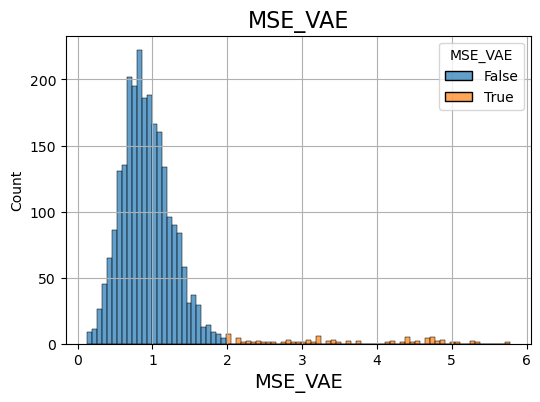

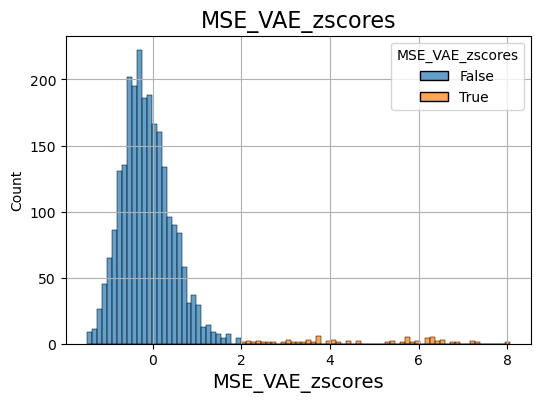

In [20]:
df["MSE_VAE"] = sample_errors_np
create_histo_1d("MSE_VAE","MSE_VAE",threshold=2,dataset=df)
create_histo_1d("MSE_VAE_zscores","MSE_VAE_zscores",threshold=2, dataset=df)

Here once again we can see that the value of 2 separates the anamolous and te ordinary transactions pretty nicely. I will choose the value of 2 as the trhreshold for fraud when using the Z scores because that provides a statistically motivated reason.

In [23]:
df['MSE_VAE_Fraud'] = df['MSE_VAE_zscores'] > 2

fraud_count =(df["MSE_VAE_Fraud"]==True).sum()

# Of all the cases, there are some that have a statistical anomaly enough for the autoencoder to pick up, and constitute fraud, these are
print("{} out of {} data entries have fraud characteristics, or {}% of the sample".format(fraud_count, df["MSE_VAE"].count(),100*fraud_count/df["MSE_VAE"].count()))

68 out of 2512 data entries have fraud characteristics, or 2.7070063694267517% of the sample


# Exporting the data

Lets export this dataset, so that we can make comparisons as to which transactions were flagged as fraud across methods

In [24]:
df.to_csv("./identified_fraud_variational_autoencoder.csv")